In [15]:
import numpy as np
import pandas as pd
from sklearn import *
import tensorflow as tf
import matplotlib.pyplot as plt
from math import ceil

In [4]:
tf.__version__

'1.7.0-rc1'

In [5]:
class CifarLoader(object):
    """
    Loads CIFAR10 dataset
    
    """
   
    def load_data(self, files):
        import pickle
        import numpy as np
        X = np.empty([0, 3072])
        y = np.empty([0])
        for path in files:
            print(path)
            with open(path, "rb") as f:
                d = pickle.load(f, encoding='bytes')
                X = np.vstack([X, d[b"data"]]).astype("uint8")
                y = np.hstack([y, d[b"labels"]]).astype("uint8")
        return X, y
        
    def __init__(self, data_path):
        import os, pickle
        
        training_files = [os.path.join(data_path, "data_batch_{0}".format(i))  for i in range(1, 6)]
        test_files = [os.path.join(data_path, "test_batch")]
        labels_file = os.path.join(data_path, "batches.meta")

        X_train, y_train = self.load_data(training_files)
        X_test, y_test = self.load_data(test_files)
        
        self.X_train = X_train.reshape([-1, 3, 32, 32]).transpose([0, 2, 3, 1])/255
        self.X_test = X_test.reshape([-1, 3, 32, 32]).transpose([0, 2, 3, 1])/255
        self.y_train = y_train
        self.y_test = y_test
        
        with open(labels_file, "rb") as f:
            labels = pickle.load(f, encoding="bytes")
        labels = [s.decode("utf-8")  for s in labels[b'label_names']]
        
        self.labels = labels
    
    def __repr__(self):
        row_format ="{:<15}" * 2
        lines = [
            row_format.format("X_train", str(self.X_train.shape)),
            row_format.format("X_test", str(self.X_test.shape)),
            row_format.format("y_train", str(self.y_train.shape)),
            row_format.format("y_test", str(self.y_test.shape)),
            row_format.format("labels", str(self.labels))
        ]
        return "\n".join(lines)


In [9]:
cifar = CifarLoader("/data/cifar-10-batches-py")
cifar

/data/cifar-10-batches-py/data_batch_1
/data/cifar-10-batches-py/data_batch_2
/data/cifar-10-batches-py/data_batch_3
/data/cifar-10-batches-py/data_batch_4
/data/cifar-10-batches-py/data_batch_5
/data/cifar-10-batches-py/test_batch


X_train        (50000, 32, 32, 3)
X_test         (10000, 32, 32, 3)
y_train        (50000,)       
y_test         (10000,)       
labels         ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [36]:
import pickle

data = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test, "labels": cifar.labels}
with open("/data/cifar.pickle", "wb") as f:
    pickle.dump(data, f)

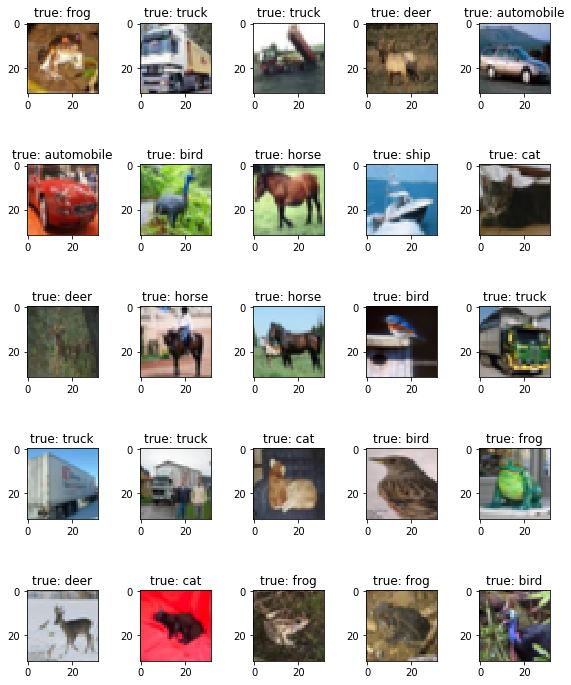

In [32]:
X_train = cifar.X_train
y_train = cifar.y_train
X_test = cifar.X_test
y_test = cifar.y_test

fig, _ = plt.subplots(5, 5, figsize = (8, 10))

for i, ax in enumerate(fig.axes):
    img = X_train[i]
    label = cifar.labels[y_train[i]]
    ax.imshow(img)
    ax.set_title("true: " + str(label))
    
plt.tight_layout()

In [27]:
n_x = X_train.shape[1]
n_y = len(cifar.labels)
n_H, n_W, n_C = 32, 32, 3 
n_h = 400
epochs = 10
batch_size = 16
batch_count = ceil(X_train.shape[0]/batch_size)

tf.reset_default_graph()
tf.set_random_seed(1)

learning_rate = 0.001

X =tf.placeholder(dtype=tf.float32, shape = [None, n_H, n_W, n_C])
y =tf.placeholder(dtype=tf.int32, shape = [None])
keep_prob = tf.placeholder_with_default(1.0, shape = [])

y_oh =tf.one_hot(indices = y, depth = n_y)

def full_layer(name, input, size, activation = None):
    input_size = int(input.get_shape()[1])
    W = tf.get_variable(name=name + "_W", shape=[input_size, size], 
                initializer=tf.contrib.layers.xavier_initializer())
    b = tf.Variable(tf.zeros([size]))
    Z = tf.matmul(input, W) + b
    
    if not activation is None:
        Z = activation(Z)
    
    Z = tf.nn.dropout(Z, keep_prob = keep_prob)
    
    return Z

def conv_layer(name, input, shape, strides, padding = "VALID"):
    W = tf.get_variable(name + "_W", shape = shape, 
                        initializer=tf.contrib.layers.xavier_initializer())
    b = tf.Variable(tf.zeros([shape[3]]))
    
    A = tf.nn.conv2d(input, W, strides, padding)
    A = tf.nn.relu(A + b)
    
    return A

def pooling_layer(input, ksize, strides, padding = "VALID"):
    A = tf.nn.max_pool(value = input, ksize = ksize, strides = strides, padding = padding)
    return A
    

conv1 = conv_layer("c1", X, shape =  [5, 5, 3, 32], strides = [1, 1, 1, 1])
print("conv1", conv1)
pool1 = pooling_layer(conv1,ksize=[1, 2, 2, 1],strides= [1, 2, 2, 1])
print("pool1", pool1)

conv2 = conv_layer("c2", pool1, shape = [5, 5, 32, 64],strides = [1, 1, 1, 1])
print("conv2", conv2)
pool2 = pooling_layer(conv2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1])
print("pool2", pool2)


pool2_shape = pool2.get_shape()

total_size = pool2_shape[1] * pool2_shape[2] * pool2_shape[3]
print("Total size", total_size)
flatten = tf.reshape(pool2, [-1, total_size])


full_layer1= full_layer("fc1", flatten, n_h, activation = tf.nn.relu)
print("full_layer1", full_layer1)
full_layer2= full_layer("fc2", full_layer1, n_y)
print("full_layer2", full_layer2)

Z = full_layer2

y_pred = tf.argmax(Z, axis=1, output_type=tf.int32) 
print("y_pred", y_pred)

accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred, y), tf.float32))

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits=Z))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(epochs):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]
        for j in range(batch_count):
            X_batch = X_train[j*batch_size:(j+1)*batch_size]
            y_batch = y_train[j*batch_size:(j+1)*batch_size]
            sess.run(optimizer, feed_dict={X: X_batch, y: y_batch, keep_prob: 0.6})

        train_accuracy_ = sess.run(accuracy, feed_dict={X: X_batch, y: y_batch})
        test_accuracy_ = sess.run(accuracy, feed_dict={X: X_test[:128], y: y_test[:128]})
        print("epoch", i, "training accuracy: ", train_accuracy_, "test accuracy", test_accuracy_)


conv1 Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
pool1 Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
conv2 Tensor("Relu_1:0", shape=(?, 10, 10, 64), dtype=float32)
pool2 Tensor("MaxPool_1:0", shape=(?, 5, 5, 64), dtype=float32)
Total size 1600
full_layer1 Tensor("dropout/mul:0", shape=(?, 400), dtype=float32)
full_layer2 Tensor("dropout_1/mul:0", shape=(?, 10), dtype=float32)
y_pred Tensor("ArgMax:0", shape=(?,), dtype=int32)
epoch 0 training accuracy:  0.0 test accuracy 0.1328125
epoch 1 training accuracy:  0.0625 test accuracy 0.0703125


KeyboardInterrupt: 